In [1]:
# import utility libraries
from netCDF4 import Dataset
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
%matplotlib inline

# import machine learning tools
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Convolution2D, AveragePooling2D, Convolution3D, AveragePooling3D
from keras.optimizers import SGD
from sklearn.metrics import roc_auc_score, accuracy_score

from clustering import Location_Clusterer
from util import plot_list_in_2D, reformat_y, plot_compare_map, scale_data, eval_classifier_model, eval_regressor_model



Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN not available)
/home/ubuntu/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
n_clusters = 8
folder = '/home/ubuntu/dataset/'
files = ['veg.nc', 'ppt.monthly.mask.nc', 'tmean.monthly.mask.nc', 'elev.nc']
var_names = ['Cv', 'Band1', 'Band1', 'elev']

lc = Location_Clusterer(n_clusters=n_clusters)
for f, var in zip(files, var_names):
    lc.read_data(folder+f, var)

lc.transform_data()
clusters = lc.fit_predict(lc.data2d)

In [3]:
from nn_input import NN_Input

folder = '/home/ubuntu/dataset/int_weather/'
nn = NN_Input(predict=2, history=2, box=5, random_seed=42)
nn.load_labels(folder+'all.ndvi.normed.nc', 'Band1')

# f_paths = ['all.ndvi.nc','all.max.of.Wind.nc', 'all.min.of.Tmin.nc', 'all.mean.of.Tmin.nc', 'all.sum.of.Prec.nc',
#            'all.max.of.Tmax.nc', 'all.mean.of.Tmax.nc','elev.nc', 'veg.nc']
# variables = ['Band1', 'Wind', 'Tmin', 'Tmin', 'Prec', 'Tmax', 'Tmax', 'elev', 'Cv']
# names = ['ndvi', 'max_wind', 'min_tmin', 'mean_tmin', 'total_prec', 'max_tmax', 'mean_tmax', 'elev', 'veg']
# feature_types = ['history_time_series', 'forecast_time_series', 'forecast_time_series', 'forecast_time_series',
#                  'forecast_time_series', 'forecast_time_series', 'forecast_time_series',
#                 'single_layer', 'multi_layers']

f_paths = ['all.mean.of.Tmin.nc', 'all.mean.of.Tmin.nc' , 'all.min.of.Tmin.nc', 'all.min.of.Tmin.nc', 
           'all.sum.of.Prec.nc', 'all.sum.of.Prec.nc', 'all.max.of.Wind.nc', 'all.max.of.Wind.nc']
variables = ['Tmin', 'Tmin', 'Tmin', 'Tmin', 'Prec', 'Prec', 'Wind', 'Wind']
names = ['mean_tmin_history', 'mean_tmin_forecast', 'min_tmin_history', 'min_tmin_forecast',
         'sum_prec_history', 'sum_prec_forecast', 'max_wind_history', 'max_wind_forecast']
feature_types = ['history_time_series', 'forecast_time_series', 'history_time_series', 'forecast_time_series',
                'history_time_series', 'forecast_time_series', 'history_time_series', 'forecast_time_series']

# f_paths = ['all.mean.of.Tmin.nc', 'all.mean.of.Tmin.nc']
# variables = ['Tmin', 'Tmin']
# names = ['mean_tmin_history', 'mean_tmin_forecast']
# feature_types = ['history_time_series', 'forecast_time_series']

for f_path, v, n, feature_type in zip(f_paths, variables, names, feature_types):
    nn.load_features(folder+f_path, v, n, feature_type)


In [4]:
point = [308, 290]
for i, loc in enumerate(lc.ind2d):
    if loc[0] == point[0] and loc[1] == point[1]:
        cluster = clusters[i]

print 'Modeling for cluster', cluster
subset = lc.ind2d[clusters==cluster]

Modeling for cluster 7


In [5]:
print 'Getting training dataset'
id_train, y_train, X_map_train = nn.select(n=100000, subset=subset, ndim_out=4)

print 'Getting testing dataset'
# t = (len(nn.times)/2) + 1
# id_test, y_test, X_map_test = nn.select(t=t, subset=subset)
id_test, y_test, X_map_test = nn.select(n=100000, cutoff=-200, subset=subset, ndim_out=4)

map_dimensions=X_map_train[0].shape
print 'Feature dimensions are:', map_dimensions


Getting training dataset
Getting testing dataset
Feature dimensions are: (24, 11, 11)


In [6]:
print 'Standardizing data'
n_var = 4 # or len(nn.variables)
n_layers = map_dimensions[0]/n_var
mean_train = []
std_train = []
X_train = np.zeros(X_map_train.shape)
X_test = np.zeros(X_map_test.shape)

for i in xrange(n_var):
    X_slice = X_map_train[:,i*n_layers:(i+1)*n_layers]
    valid_vals = X_slice[X_slice != -999].flatten()
    
    mean_train.append(np.mean(valid_vals))
    std_train.append(np.std(valid_vals))
    X_train[:,i*n_layers:(i+1)*n_layers,:,:] = scale_data(X_map_train[:,i*n_layers:(i+1)*n_layers,:,:], mean_train[i], std_train[i])
    X_test[:,i*n_layers:(i+1)*n_layers,:,:] = scale_data(X_map_test[:,i*n_layers:(i+1)*n_layers,:,:], mean_train[i], std_train[i])
print 'Done reformatting, data ready for neural network'


Standardizing data
Done reformatting, data ready for neural network


In [10]:
def build_regressor_NN(ndim_conv=2, n_conv_layers=3, nb_filters=64, nb_conv=3, map_dimensions=None, 
                       nb_pool=2, optimizer='rmsprop'):

    model = Sequential() 
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv,input_shape=map_dimensions))
    model.add(Activation('sigmoid'))
#     model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
#     model.add(Activation('sigmoid'))
    model.add(AveragePooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.25))    
  
    
    model.add(Flatten())
    #model.add(Dense(128, activation='linear'))
    model.add(Dense(128, activation='linear'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='linear'))
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mae', optimizer=optimizer)
    return model

In [11]:
# optimizers = ['adadelta', 'adagrad', 'rmsprop', 'adam']
optimizers = ['adagrad']

for opt in optimizers:
    print opt
    model = build_regressor_NN(ndim_conv=2, nb_filters=64, map_dimensions=map_dimensions, optimizer=opt)
    model.fit(X_train, y_train, batch_size=20, nb_epoch=1, verbose=True, validation_data=(X_test, y_test))
    eval_regressor_model(model, cluster, X_train, y_train, X_test, y_test)


adagrad
Train on 100000 samples, validate on 100000 samples
Epoch 1/1
   840/100000 [..............................] - ETA: 1306s - loss: 5.0659

KeyboardInterrupt: 

Train r-squared: 0.777589972466
Test r-squared: 0.803968159294


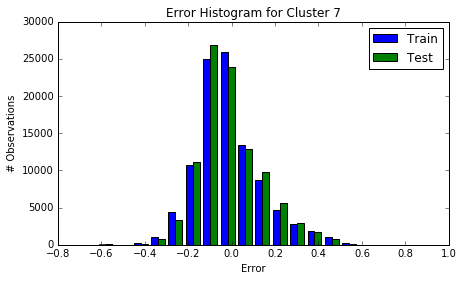

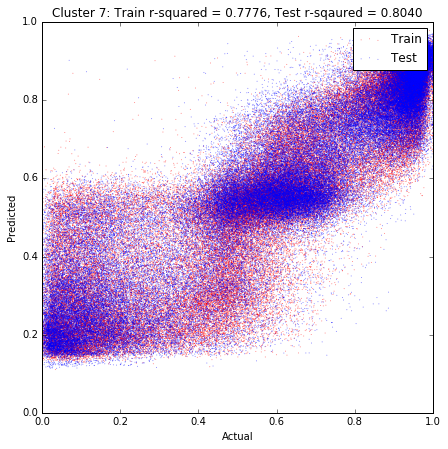

In [ ]:
image_paths = []
for t in xrange(216, 217):

    id_test, y_test, X_map_test = nn.select(t=t, subset=subset)
    for i in xrange(n_var):
        X_slice = X_map_train[:,i*n_layers:(i+1)*n_layers]

        X_train[:,i*n_layers:(i+1)*n_layers,:,:] = scale_data(X_slice, mean_train[i], std_train[i])
        X_test[:,i*n_layers:(i+1)*n_layers,:,:] = scale_data(X_slice, mean_train[i], std_train[i])
    
    timestamp = nn.times[(id_test[0,0]).astype(int)]
    xs = nn.lons[(id_test[:,2]).astype(int)]
    ys = nn.lats[(id_test[:,1]).astype(int)]
    test_predict = model.predict(X_map_test)
    
    path = plot_compare_map(xs, ys, y_test, test_predict, 
                            timestamp, s=1, folder='/home/ubuntu/dataset/output/test/')
    image_paths.append(path)

In [ ]:
# # # graph model with two inputs and one output 
# # graph = Graph() 
# # graph.add_input(name='input1', input_shape=(32,)) 
# # graph.add_input(name='input2', input_shape=(32,)) 
# # graph.add_node(Dense(16), name='dense1', input='input1') 
# # graph.add_node(Dense(4), name='dense2', input='input2') 
# # graph.add_node(Dense(4), name='dense3', input='dense1') 

# # graph.add_output(name='output', inputs=['dense2', 'dense3'], merge_mode='sum') 

# # graph.compile(optimizer='rmsprop', loss={'output':'mse'}) 
# # history = graph.fit({'input1':X_train, 'input2':X2_train, 'output':y_train}, nb_epoch=10) 
# # predictions = graph.predict({'input1':X_test, 'input2':X2_test}) # {'output':...}


# # graph model with two inputs and one output 
# model = Graph() 

# map_dimensions=train_X_map[0][0].shape

# # two types of inputs: maps in 3D matrix and a list
# model.add_input(name='maps', input_shape=train_X_map[0].shape) 
# model.add_input(name='lst', input_shape=train_X_lst[0].shape) 

# # adding layers to process the maps
# # 
# model.add_node(Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering='th')
#                , name='map_conv1', input='maps')
# # add pooling layers
# model.add_node(Flatten(), name='map_flatten', input='map_conv1')
# model.add_node(Dense(64), name='map_dense1', input='map_flatten')

# # adding layers to process the lst
# model.add_node(Dense(16), name='lst_dense1', input='lst') 
# model.add_node(Dense(8), name='lst_dense2', input='lst_dense1')

# # merging two sets of weights
# model.add_node(Dense(72, activation='relu'), name='combine', inputs=['map_flatten', 'lst_dense1'], merge_mode='concat')
# model.add_node(Dense(1, activation='sigmoid'), name='reduce', input='combine')
# model.add_output(name='output', input='reduce')

# sgd = SGD(lr=0.001)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

# # use dropouts 
# # try different solver
# # if acc = 0, network diverged, reduce step size

# def build_regressor_NN(n_conv_layers=2, nb_filters=64, nb_conv=3, map_dimensions=None, nb_pool=2):

#     model = Sequential()
#     model.add(Convolution2D(nb_filters, nb_conv, nb_conv,input_shape=map_dimensions))
#     model.add(Activation('relu'))
#     model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
#     model.add(Dropout(0.25))

#     model.add(Flatten())
#     model.add(Dense(128))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(32))
#     model.add(Activation('relu'))
#     model.add(Dense(1))

#     model.compile(loss='mse', optimizer='rmsprop')
#     return model

In [ ]:
# model.fit({'maps': train_X_map, 'lst': train_X_lst, 'output': train_y}, nb_epoch=10, batch_size=10, verbose=True)

In [ ]:
# prediction = model.predict({'maps': np.array(test_X_map), 'lst': np.array(test_X_lst)}, batch_size=1000)